In [1]:
import datetime
import Date
import pandas as pd
import numpy as np
import Forecast
import Date
import Demand
import requests
import matplotlib.pyplot as plt
import Price
import Solar

In [2]:
def predictedcharge(bigdata, daywanted):
    
    slope_intercept = pd.read_csv('Data/regression_values.csv')
    
    date = Date.getdatewanted(daywanted, 2014)
    month = Date.getmonth(date)

    slope = slope_intercept['slope'][month-1]
    intercept = slope_intercept['intercept'][month-1]

    cloud = Forecast.getcloudcover(daywanted)

    predicted_insolance = slope*cloud+intercept
    
    predictedcharge = predicted_insolance*1600*0.9
    
    daydemand = []
    for n in range(24):
        if bigdata['Total Supply (kWh)'][n] > 0:
            daydemand.append(bigdata['Total Demand (kWh)'][n])
        
    predictedcharge = predictedcharge-np.sum(daydemand)
    
    return predictedcharge

In [3]:
def chargeneeded(bigdata):

    eff = 0.9
    chargeneeded = 0
    median = np.median(bigdata['Grid Buy Price'])
    batterycharge = 0
    

    for n in range(0,24):
            
        if bigdata['Grid Buy Price'][n] >= median*1.5:
            chargeneeded = chargeneeded + bigdata['Net Demand'][n]/(eff)


    return chargeneeded

In [4]:
## method to run the SMART system ##
## if its predicted

def run_SMART(bigdata, daywanted, starting_soc):
    
    batteryoutput = np.zeros(24)
    soc = np.ones(24)*0
    capacity = 1120
    power = 415
    eff = 0.9
    
    median = np.median(bigdata['Grid Buy Price'])
    required_battery_charge = chargeneeded(bigdata)
    predicted_battery_charge = predictedcharge(bigdata, daywanted)
    
    print(required_battery_charge, predicted_battery_charge)
    
    for n in range(0,24):
        
        if n == 0:
            soc_temp = starting_soc[daywanted-1]
        else:
            soc_temp = soc[n-1]

        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        
        if required_battery_charge > predicted_battery_charge: 
            if n == 5:
                batteryoutput[n] = max(-power, -(1/eff)*(required_battery_charge - predicted_battery_charge))
                soc[n] = soc_temp - batteryoutput[n]*eff
                continue
                
        if n == 0:
            use = True
        if n == 14:
            use = False
        if bigdata['Grid Buy Price'][n] >= median*1.5:
            use = True
            
#         use = True
        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        if bigdata['Net Demand'][n] > 0:   #using the battery
            batteryoutput[n] = min(bigdata['Net Demand'][n], soc_temp*eff, power)
            soc[n] = soc_temp - batteryoutput[n]*(1/eff)
            if use == False:
                soc[n] = soc[n-1]
                batteryoutput[n] = 0

        elif bigdata['Net Demand'][n] < 0:     # charge the battery
            batteryoutput[n] = max(bigdata['Net Demand'][n], -(1/eff)*(capacity - soc_temp), -power)
            soc[n] = soc_temp - batteryoutput[n]*(eff)

        elif bigdata['Net Demand'][n] == 0:      # do nothing
            soc[n] = soc_temp

        
    ## adds the battery output to total demand and adds to bigdata ##

    bigdata['Net Demand - SMART'] = bigdata['Net Demand']-batteryoutput
    bigdata['Running Cost - SMART'] = bigdata['Net Demand - SMART']*bigdata['Grid Buy Price']
    bigdata['Running Cost - SMART'] = bigdata['Running Cost - SMART'].clip(lower=0)
    bigdata['Running Profit - SMART'] = -bigdata['Net Demand - SMART']*bigdata['Grid Sell Price']
    bigdata['Running Profit - SMART'] = bigdata['Running Profit - SMART'].clip(lower=0)
    bigdata['soc - SMART'] = soc
    bigdata['battery output - SMART'] = batteryoutput
    
    ## adds the end day soc into the global vector to use for the next day ##
    starting_soc[daywanted] = soc[23]
    ## returns the new bigdata ##
    
    return bigdata

In [5]:
starting_soc = np.zeros(366)
SMART_cost = np.zeros(365)
SMART_profit = np.zeros(365)
_import_ = np.zeros(24)
_export_ = np.zeros(24)

''''''

n = 350
daywanted = n+1
datewanted = Date.getdatewanted(daywanted, 2014)
totaldemand = Demand.gettotaldemand(daywanted)
solarsupply = Solar.getsolarsupply(daywanted)
buyprice = Price.getvariablebuyprice(daywanted)
sellprice = Price.getvariablesellprice(daywanted)
bigdata =pd.concat([totaldemand, solarsupply, buyprice, sellprice], axis=1)
bigdata['Net Demand'] = bigdata['Total Demand (kWh)']-bigdata['Total Supply (kWh)']
bigdata['Running Cost'] = bigdata['Grid Buy Price']*bigdata['Net Demand']
bigdata['Running Cost'] = bigdata['Running Cost'].clip(lower=0)
bigdata['Running Profit'] = -bigdata['Grid Sell Price']*bigdata['Net Demand']
bigdata['Running Profit'] = bigdata['Running Profit'].clip(lower=0)

bigdata = run_SMART(bigdata, daywanted, starting_soc)

for q in range(24):
    
        if bigdata['Net Demand - SMART'][q] < 0:
            _export_[q] = bigdata['Net Demand - SMART'][q]*-1
            
        if bigdata['Net Demand - SMART'][q] > 0:
            _import_[q] = bigdata['Net Demand - SMART'][q]


286.7862830439815 -382.7926560113341


In [6]:
median = np.median(bigdata['Grid Buy Price'])
one = np.zeros(24)
two = np.zeros(24)
for n in range(24):
    if bigdata['Grid Buy Price'][n] >= median*1.5:
        one[n] = bigdata['Net Demand'][n]
    else:
        one[n] = 0
        
    if bigdata['Net Demand'][n] <=0:
        two[n] = bigdata['Net Demand'][n]
    else:
        two[n] = 0

/Users/oliver/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
/Users/oliver/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
/Users/oliver/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
/Users/oliver/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWar

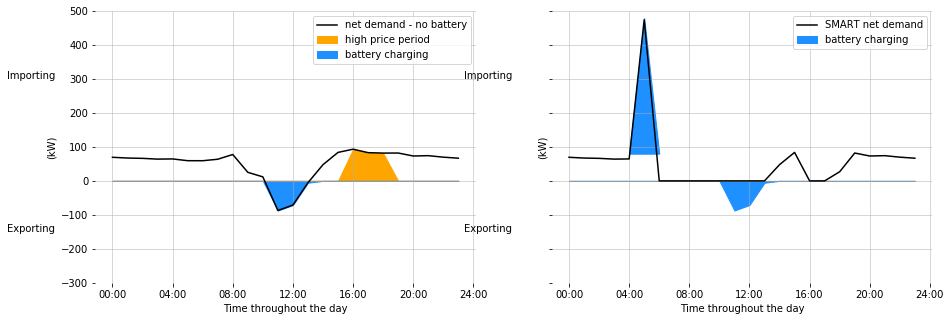

In [7]:
x = [d for d in range(24)]
hi = [4,5,6]
hello = [80,479,80]
zero=np.zeros(24)
fig, ax = plt.subplots(1,2, sharey=True,figsize=[15,5])

# ax[0].step(x,bigdata['Net Demand'])
ax[0].fill_between(x,one,0,color='orange',label='high price period')
ax[0].fill_between(x,two,0,color='dodgerblue',label='battery charging')
ax[0].plot(bigdata['Net Demand'],color='black',label='net demand - no battery')
ax[0].fill_between(x,zero,color='grey')
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel('Time throughout the day', fontsize=10)
ax[0].set_ylabel('(kW)',fontsize=10)
ax[0].set_xticks((0,4,8,12,16,20,24))
ax[0].set_xticklabels(('00:00','04:00','08:00','12:00','16:00','20:00','24:00'))
ax[0].legend()
ax[0].set_ylim(-300,500)
ax[0].text(-7, 300, 'Importing', fontdict=None, withdash=False)
ax[0].text(-7, -150, 'Exporting', fontdict=None, withdash=False)
ax[0].grid(lw=0.5)
# ax[0].grid()
# ax[0].plot(x,linewidth=3,color='white')
# ax2 = ax[0].twinx()
# ax2.step(x,buyprice,color='darkorange')

ax[1].plot(x,bigdata['Net Demand - SMART'],color='black',label='SMART net demand')
# ax[1].fill_between(x,bigdata['soc - SMART'],color='dodgerblue',label='battery SOC')
ax[1].fill_between(x,two,0,color='dodgerblue',label='battery charging')
ax[1].fill_between(hi,hello,80,color='dodgerblue')
ax[1].fill_between(x,zero,color='grey')
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Time throughout the day', fontsize=10)
ax[1].set_ylabel('(kW)',fontsize=10)
ax[1].set_xticks((0,4,8,12,16,20,24))
ax[1].set_xticklabels(('00:00','04:00','08:00','12:00','16:00','20:00','24:00'))
ax[1].text(-7, 300, 'Importing', fontdict=None, withdash=False)
ax[1].text(-7, -150, 'Exporting', fontdict=None, withdash=False)
ax[1].legend()
ax[1].grid(lw=0.5)

In [8]:
one = np.append(one,one[23])
two = np.append(two,two[23])
zero = np.append(zero,zero[23])

bd1 = np.array(bigdata['Net Demand'])
bd2 = np.array(bigdata['Net Demand - SMART'])
bd1 = np.append(bd1,bd1[23])
bd2 = np.append(bd2,bd2[23])

/Users/oliver/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
/Users/oliver/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.


Text(0.5, 1.0, 'SMART')

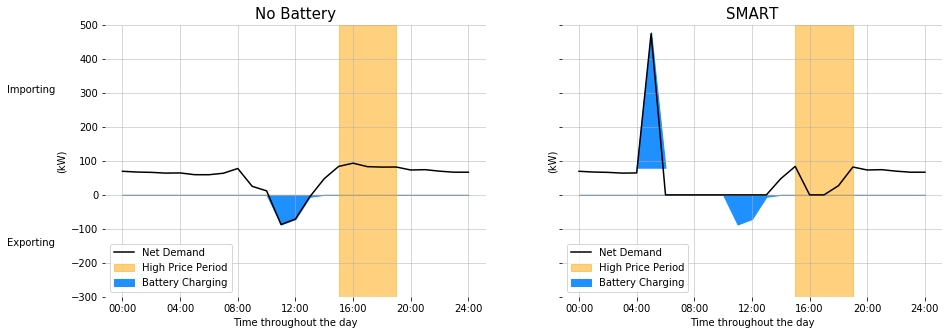

In [28]:
x = [d for d in range(25)]
hi = [4,5,6]
hello = [80,479,80]
# zero=np.zeros(24)
fig, ax = plt.subplots(1,2, sharey=True,figsize=[15,5])

# ax[0].step(x,bigdata['Net Demand'])
# ax[0].fill_between(x,one,0,color='orange',label='high price period')
ax[0].axvspan(15, 19, alpha=0.5, color='orange',label='High Price Period')
ax[0].fill_between(x,two,0,color='dodgerblue',label='Battery Charging')
ax[0].plot(bd1,color='black',label='Net Demand')
ax[0].fill_between(x,zero,color='grey')
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel('Time throughout the day', fontsize=10)
ax[0].set_ylabel('(kW)',fontsize=10)
ax[0].set_xticks((0,4,8,12,16,20,24))
ax[0].set_xticklabels(('00:00','04:00','08:00','12:00','16:00','20:00','24:00'))
ax[0].legend(loc='lower left')
ax[0].set_ylim(-300,500)
ax[0].text(-8, 300, 'Importing', fontdict=None, withdash=False)
ax[0].text(-8, -150, 'Exporting', fontdict=None, withdash=False)
ax[0].grid(lw=0.5)
ax[0].set_title('No Battery',fontsize=15)
# ax[0].grid()
# ax[0].plot(x,linewidth=3,color='white')
# ax2 = ax[0].twinx()
# ax2.step(x,buyprice,color='darkorange')

ax[1].plot(x,bd2,color='black',label='Net Demand')
# ax[1].fill_between(x,bigdata['soc - SMART'],color='dodgerblue',label='battery SOC')
ax[1].fill_between(x,two,0,color='dodgerblue',label='Battery Charging')
ax[1].fill_between(hi,hello,80,color='dodgerblue')
ax[1].fill_between(x,zero,color='grey')
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Time throughout the day', fontsize=10)
ax[1].set_ylabel('(kW)',fontsize=10)
ax[1].set_xticks((0,4,8,12,16,20,24))
ax[1].set_xticklabels(('00:00','04:00','08:00','12:00','16:00','20:00','24:00'))
# ax[1].text(-4, 300, 'Importing', fontdict=None, withdash=False)
# ax[1].text(-4, -150, 'Exporting', fontdict=None, withdash=False)
ax[1].axvspan(15, 19, alpha=0.5, color='orange',label='High Price Period')
ax[1].legend()
ax[1].grid(lw=0.5)
ax[1].set_title('SMART',fontsize=15)
